In [16]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
import seaborn as sns
import sys
import scipy.stats as sc
import pandas as pd
import ffl

sys.path.append('../External_Functions')
from ExternalFunctions import UnbinnedLH, Chi2Regression, BinnedLH
from ExternalFunctions import nice_string_output, add_text_to_ax  # Useful functions to print fit results on figure

sns.set()
sns.set_context("paper", font_scale=1.4)
sns.set_style("ticks")

colors = sns.color_palette('deep', 10, desat = 1)
sns.set_palette(colors)
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.axis'] = 'y'
plt.rcParams['axes.grid.which'] = 'major'
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 2
plt.rcParams['figure.figsize'] = (16, 9)


# 3.1 - You shoot a penalty, and the probability of scoring depends on the position x (in m) you hit, as pscore = |x|/4 m for |x|< 4 m and zero otherwise (outside goal). Assume the ball hits the goal where you aim with an uncertainty of one meter.

# 3.1.1 - What is the chance of scoring, if you aim at x = 2.5m?

If i understand the question correctly, i assume that every shot I take, is gaussianly distributed with $\mu = 2.5$ and $\sigma = 1$. For my simulation, i take $N_{total} = 1000$ shots. Then i calculate the probability of me scoring using the given formula, but if $|x| > 4 $ I set the probability to 0. And finally the probability of scoring is then caculated as the average scoring probability for a specific $x$, here $x=2.5$


In [17]:

def pscore(x):
    return np.abs(x)/4


def pen(x, N_shots = 1000):
    shots = np.random.normal(x, 1, N_shots)
    p_list = pscore(shots)

    miss = np.abs(shots) > 4
    p_list[miss] = 0

    mean_p = np.mean(p_list)

    return shots, p_list, mean_p



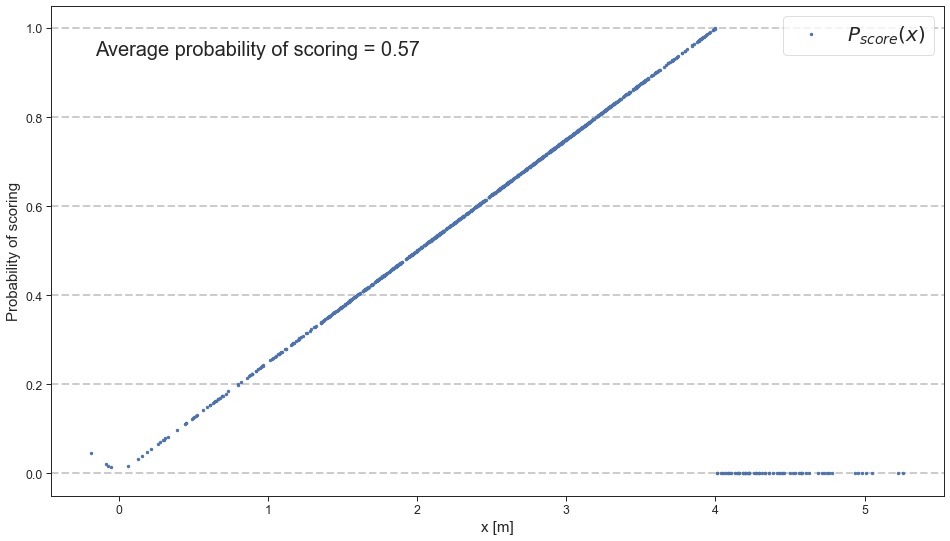

In [18]:

shots_25,  p_list_25, mean_p_25 = pen(2.5)

fig, ax = plt.subplots()

ax.plot(shots_25, p_list_25, label = r'$P_{score}(x)$', marker = '.', linestyle = 'None')
ax.text(0.05, 0.9, f'Average probability of scoring = {mean_p_25:.2f}', transform = ax.transAxes, fontsize = 20)
ax.set_xlabel('x [m]', fontsize = 15)
ax.set_ylabel('Probability of scoring', fontsize = 15)
ax.legend(fontsize = 20)

plt.savefig('saved_images/3_1_1.png')

## 3.1.2 - Where should you aim to have the highest probability of scoring?

Here i essentially follow the same procedure, but now i loop over x-values between $x = [-4, 4]$. This gives me a distribution of average probabilities as a function of $x$.


For finding the x with the highest average probability, i fit the distribution with a parabola on one of the two sides, and from the fit values I then calculated the $x_{max} = \frac{-a}{2b}$ where $a$ and $b$ are the fit parameters. The results are shown in the plot and the location with the highest probability of scoring was found to be:

$$ x = \pm 2.864 \text{m}$$

In [19]:
x_range = np.linspace (-4, 4, 1000)


p_mean_list = []
p_std_list = []
for x in x_range:
    p_x = []
    for i in range(100):
        _, _, p_mean = pen(x)
        p_x.append(p_mean)
    p_mean_list.append(np.mean(p_x))
    p_std_list.append(np.std(p_x))

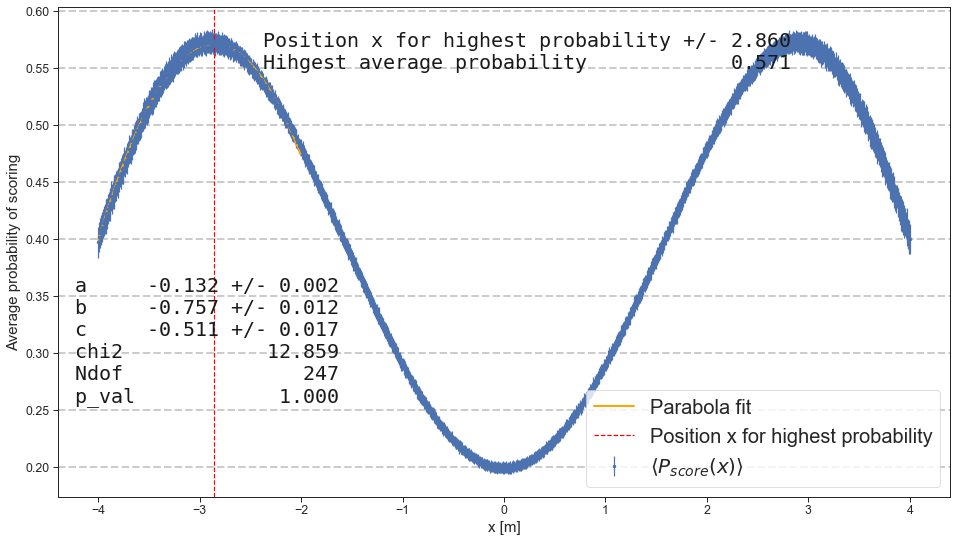

In [20]:

# Estimate the peak of the distribution with a parabola
def parabola(x, a, b, c):
    return a*x**2 + b*x + c

fit_range = x_range[0: 250]
p_mean_fit = p_mean_list[0: 250]
p_std_fit = p_std_list[0: 250]

minuit, ndof, p_val, par_dict = ffl.fit_with_chi2(parabola, fit_range, p_mean_fit, p_std_fit, func_par = [1, 1, 1])
y_plot = parabola(fit_range, *minuit.values[:])


x_top_val = -minuit.values[1]/(2*minuit.values[0])
top_val = parabola(x_top_val, *minuit.values[:])

# Create new dictionary with top val
top_val_dict = { 'Position x for highest probability +/-': -1 * x_top_val,
                 'Hihgest average probability': top_val}


fig, ax = plt.subplots()

ax.plot(fit_range, y_plot, label = 'Parabola fit', color = 'orange', linewidth=2)
nice_string = nice_string_output(top_val_dict, extra_spacing = 1, decimals = 3)
nice_string_fit = nice_string_output(par_dict, extra_spacing = 1, decimals = 3)
add_text_to_ax(0.23, 0.95, nice_string, ax, fontsize = 20)
add_text_to_ax(0.02, 0.45, nice_string_fit, ax, fontsize = 20)

ax.errorbar(x_range, p_mean_list, yerr=p_std_list, label = r'$\langle P_{score}(x) \rangle$', marker = '.', linestyle = 'None')
ax.set_xlabel('x [m]', fontsize = 15)
ax.axvline(x_top_val, color = 'red', linestyle = '--', label = 'Position x for highest probability')
ax.set_ylabel('Average probability of scoring', fontsize = 15)
ax.legend(loc= 'lower right', fontsize = 20)

plt.savefig('saved_images/3_1_2.png')
